In [1]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt
import astropy
from astropy.io import fits, ascii
from astropy.table import Table, Column
import scipy
import pickle
from scipy.stats import poisson
from scipy.misc import factorial
import pymc3 as pm
from theano.compile.ops import as_op
import theano.tensor as T
from astropy.convolution import convolve, Gaussian2DKernel, Tophat2DKernel
from astropy.modeling.models import Gaussian2D

Populating the interactive namespace from numpy and matplotlib


In [2]:
def rebin(array, dimensions=None, scale=None):
    """ Return the array ``array`` to the new ``dimensions`` conserving flux the flux in the bins
    The sum of the array will remain the same
 
    >>> ar = numpy.array([
        [0,1,2],
        [1,2,3],
        [2,3,4]
        ])
    >>> rebin(ar, (2,2))
    array([
        [1.5, 4.5]
        [4.5, 7.5]
        ])
    Raises
    ------
 
    AssertionError
        If the totals of the input and result array don't agree, raise an error because computation may have gone wrong
 
    Reference
    =========
    +-+-+-+
    |1|2|3|
    +-+-+-+
    |4|5|6|
    +-+-+-+
    |7|8|9|
    +-+-+-+
    """
    if dimensions is not None:
        if isinstance(dimensions, float):
            dimensions = [int(dimensions)] * len(array.shape)
        elif isinstance(dimensions, int):
            dimensions = [dimensions] * len(array.shape)
        elif len(dimensions) != len(array.shape):
            raise RuntimeError('')
    elif scale is not None:
        if isinstance(scale, float) or isinstance(scale, int):
            dimensions = map(int, map(round, map(lambda x: x*scale, array.shape)))
        elif len(scale) != len(array.shape):
            raise RuntimeError('')
    else:
        raise RuntimeError('Incorrect parameters to rebin.\n\trebin(array, dimensions=(x,y))\n\trebin(array, scale=a')
    #print(dimensions)
    #print("Rebinning to Dimensions: %s, %s" % tuple(dimensions))
    import itertools
    dY, dX = map(divmod, map(float, array.shape), dimensions)
 
    result = numpy.zeros(dimensions)
    for j, i in itertools.product(*map(range, array.shape)):
        (J, dj), (I, di) = divmod(j*dimensions[0], array.shape[0]), divmod(i*dimensions[1], array.shape[1])
        (J1, dj1), (I1, di1) = divmod(j+1, array.shape[0]/float(dimensions[0])), divmod(i+1, array.shape[1]/float(dimensions[1]))
         
        # Moving to new bin
        # Is this a discrete bin?
        dx,dy=0,0
        if (I1-I == 0) | ((I1-I == 1) & (di1==0)):
            dx = 1
        else:
            dx=1-di1
        if (J1-J == 0) | ((J1-J == 1) & (dj1==0)):
            dy=1
        else:
            dy=1-dj1
        # Prevent it from allocating outide the array
        I_=min(dimensions[1]-1,I+1)
        J_=min(dimensions[0]-1,J+1)
        result[J, I] += array[j,i]*dx*dy
        result[J_, I] += array[j,i]*(1-dy)*dx
        result[J, I_] += array[j,i]*dy*(1-dx)
        result[J_, I_] += array[j,i]*(1-dx)*(1-dy)
    allowError = 0.1
    assert (array.sum() < result.sum() * (1+allowError)) & (array.sum() >result.sum() * (1-allowError))
    return result

In [3]:
# Simulate the data
np.random.seed(2)
x0low, x0high = 3000, 4000
x1low, x1high = 4000, 4800
dx = 15
x1, x0 = np.mgrid[x1low:x1high:dx, x0low:x0high:dx]

In [4]:
# Convert to 1D arrays
shape = x0.shape
x0, x1 = x0.flatten(), x1.flatten()

In [5]:
# Create model using simulated data
from sherpa.astro.models import Beta2D
truth = Beta2D()
truth.xpos, truth.ypos = 3512, 4418
truth.r0, truth.alpha = 120, 2.1
truth.ampl = 12

In [6]:
# Evaluate the model to calculate the expected values:
mexp = truth(x0, x1).reshape(shape) 
# Create the simulated data by adding in Poisson-distributed noise:
msim = np.random.poisson(mexp)
#msim = mexp

In [7]:
print(np.shape(np.array(msim)))

(54, 67)


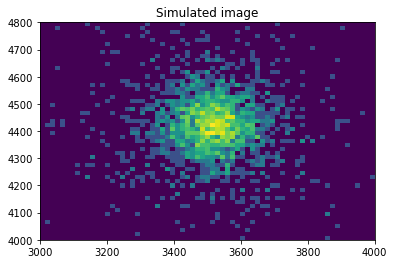

In [8]:
# Plot
plt.imshow(np.arcsinh(msim), origin='lower', cmap='viridis', 
           extent=(x0low, x0high, x1low, x1high), interpolation='nearest', aspect='auto')
plt.title('Simulated image')

In [9]:
# Rebin
msim_binned = rebin(msim,(16,13))

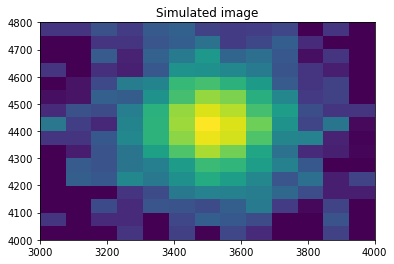

In [158]:
# Plot
plt.imshow(np.arcsinh(msim_binned), origin='lower', cmap='viridis', 
           extent=(x0low, x0high, x1low, x1high), interpolation='nearest', aspect='auto')
plt.title('Simulated image')
plt.savefig('original_img.png',dpi=300,bbox_inches='tight')

In [11]:
source_model = pm.Model()

@as_op(itypes=[T.dscalar, T.dscalar, T.dscalar, T.dscalar, T.dscalar], otypes=[T.dmatrix])
def counts_func(r0, xpos, ypos, ampl, alpha):
    truth = Beta2D()
    truth.xpos, truth.ypos = xpos, ypos
    truth.r0, truth.alpha = r0, alpha
    truth.ampl = ampl
    #truth1 = Beta2D()
    #truth1.xpos, truth1.ypos = xpos1, ypos1
    #truth1.r0, truth1.alpha = r01, alpha1
    #truth1.ampl = ampl1
    return rebin(truth(x0, x1).reshape(shape),(16,13)) #+ truth1(x0, x1).reshape(shape)
 
with source_model:
    
    # priors
    BoundedNormal = pm.Bound(pm.Normal, lower=0.1, upper=500.0)
    r0 = BoundedNormal('r0', mu=100.0, sd=80.0)
    xpos = pm.Normal('xpos', mu=3550.0, sd=100.0)
    ypos = pm.Normal('ypos', mu=4550.0, sd=100.0)
    ampl = pm.Uniform('ampl', lower=0.0, upper=50.0)
    alpha = pm.Uniform('alpha', lower=0.0, upper=10.0)
    #r01 = BoundedNormal('r01', mu=2.0, sd=5.0)
    #xpos1 = pm.Normal('xpos1', mu=3550.0, sd=100.0)
    #ypos1 = pm.Normal('ypos1', mu=4550.0, sd=100.0)
    #ampl1 = pm.Uniform('ampl1', lower=0.0, upper=5000.0)
    #alpha1 = BoundedNormal('alpha1', mu=2.0, sd=5.0)
                       
    counts = counts_func(r0, xpos, ypos, ampl, alpha)
    #counts = np.empty_like(msim)
    
    #def log_like(img):
    #    logpm = counts - img*np.log(counts)
    #    return 2.0*logpm.sum()
    
    #likelihood = pm.DensityDist("likelihood", log_like, observed=msim)                   
    likelihood = pm.Poisson('likelihood', mu=counts, observed=msim_binned)

In [12]:
from scipy import optimize

with source_model:
    map_estimate = pm.find_MAP(fmin=scipy.optimize.fmin_powell, model=source_model)
    step = pm.Slice()
    trace = pm.sample(1500,step)

/export/jgalarza/software/anaconda/lib/python3.6/site-packages/pymc3/tuning/starting.py:91: UserWarning: In future versions, set the optimization algorithm with a string. For example, use `method="L-BFGS-B"` instead of `fmin=sp.optimize.fmin_l_bfgs_b"`.
  warnings.warn('In future versions, set the optimization algorithm with a string. '
logp = -367.54:   9%|▉         | 441/5000 [00:11<01:57, 38.70it/s] 

Optimization terminated successfully.
         Current function value: 367.542826
         Iterations: 8
         Function evaluations: 444



logp = -367.54:   9%|▉         | 444/5000 [00:20<03:25, 22.16it/s]
Exception in thread Thread-4:
Traceback (most recent call last):
  File "/export/jgalarza/software/anaconda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/export/jgalarza/software/anaconda/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/export/jgalarza/software/anaconda/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 2000/2000 [36:54<00:00,  1.11s/it]


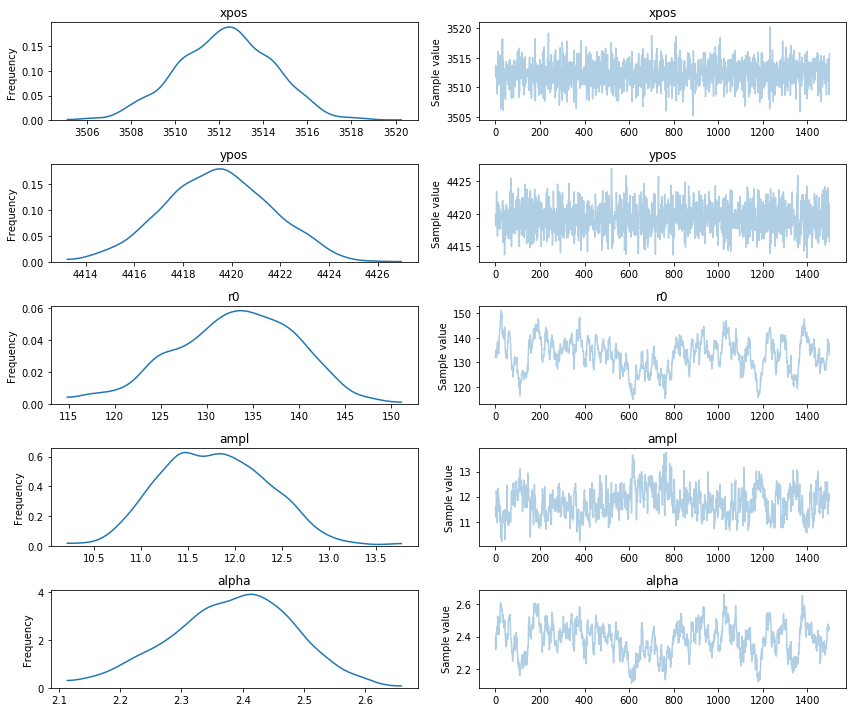

In [13]:
_ = pm.traceplot(trace)

In [159]:
# Simulate the data
np.random.seed(2)
x0low, x0high = 3000, 4000
x1low, x1high = 4000, 4800
dx = 63
x1, x0 = np.mgrid[x0low:x0high:dx, x1low:x1high:dx]
#print(x0)

# Convert to 1D arrays
shape = x0.shape
x0, x1 = x0.flatten(), x1.flatten()

In [160]:
# Create model using simulated data
from sherpa.astro.models import Beta2D
truth = Beta2D()
truth.ypos, truth.xpos = 3498, 4392
truth.r0, truth.alpha = 138, 2.32
truth.ampl = 182

In [161]:
# Evaluate the model to calculate the expected values:
mexp1 = truth(x0, x1).reshape(shape) 
# Create the simulated data by adding in Poisson-distributed noise:
msim1 = np.random.poisson(mexp1)
#msim1 = mexp1

In [162]:
print(np.shape(np.array(msim1)))

(16, 13)


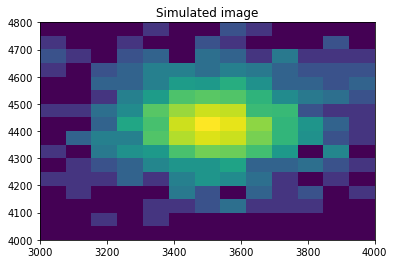

In [164]:
# Plot
plt.imshow(np.arcsinh(msim1), origin='lower', cmap='viridis', 
           extent=(x0low, x0high, x1low, x1high), interpolation='nearest', aspect='auto')
plt.title('Simulated image')
plt.savefig('sparse_grid_img.png',dpi=300,bbox_inches='tight')

In [154]:
source_model1 = pm.Model()

@as_op(itypes=[T.dscalar, T.dscalar, T.dscalar, T.dscalar, T.dscalar], otypes=[T.dmatrix])
def counts_func(r0, xpos, ypos, ampl, alpha):
    truth = Beta2D()
    truth.xpos, truth.ypos = xpos, ypos
    truth.r0, truth.alpha = r0, alpha
    truth.ampl = ampl
    #truth1 = Beta2D()
    #truth1.xpos, truth1.ypos = xpos1, ypos1
    #truth1.r0, truth1.alpha = r01, alpha1
    #truth1.ampl = ampl1
    return truth(x0, x1).reshape(shape) #+ truth1(x0, x1).reshape(shape)
 
with source_model1:
    
    # priors
    BoundedNormal = pm.Bound(pm.Normal, lower=0.1, upper=500.0)
    r0 = BoundedNormal('r0', mu=100.0, sd=80.0)
    ypos = pm.Normal('xpos', mu=3550.0, sd=100.0)
    xpos = pm.Normal('ypos', mu=4550.0, sd=100.0)
    ampl = pm.Uniform('ampl', lower=0.0, upper=500.0)
    alpha = pm.Uniform('alpha', lower=0.0, upper=10.0)
    #r01 = BoundedNormal('r01', mu=2.0, sd=5.0)
    #xpos1 = pm.Normal('xpos1', mu=3550.0, sd=100.0)
    #ypos1 = pm.Normal('ypos1', mu=4550.0, sd=100.0)
    #ampl1 = pm.Uniform('ampl1', lower=0.0, upper=5000.0)
    #alpha1 = BoundedNormal('alpha1', mu=2.0, sd=5.0)
                       
    counts = counts_func(r0, xpos, ypos, ampl, alpha)
    #counts = np.empty_like(msim)
    
    #def log_like(img):
    #    logpm = counts - img*np.log(counts)
    #    return 2.0*logpm.sum()
    
    #likelihood = pm.DensityDist("likelihood", log_like, observed=msim)                   
    likelihood = pm.Poisson('likelihood', mu=counts, observed=msim_binned)

In [155]:
from scipy import optimize

with source_model1:
    map_estimate = pm.find_MAP(fmin=scipy.optimize.fmin_powell, model=source_model)
    step = pm.Slice()
    trace = pm.sample(1500,step)

/export/jgalarza/software/anaconda/lib/python3.6/site-packages/pymc3/tuning/starting.py:91: UserWarning: In future versions, set the optimization algorithm with a string. For example, use `method="L-BFGS-B"` instead of `fmin=sp.optimize.fmin_l_bfgs_b"`.
  warnings.warn('In future versions, set the optimization algorithm with a string. '
logp = -3,296.2:   6%|▌         | 297/5000 [00:00<00:11, 395.50it/s]


Optimization terminated successfully.
         Current function value: 3295.615900
         Iterations: 5
         Function evaluations: 297


100%|██████████| 2000/2000 [00:40<00:00, 49.91it/s]


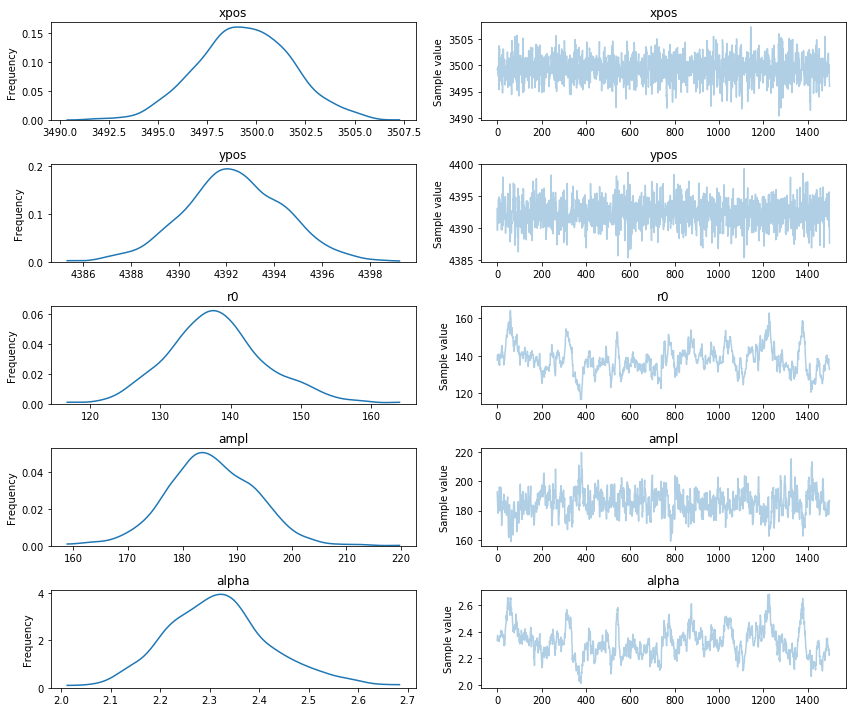

In [156]:
_ = pm.traceplot(trace)

In [172]:
# Simulate the data
np.random.seed(2)
x0low, x0high = 3000, 4000
x1low, x1high = 4000, 4800
dx = 15
x1, x0 = np.mgrid[x1low:x1high:dx, x0low:x0high:dx]

In [173]:
# Convert to 1D arrays
shape = x0.shape
x0, x1 = x0.flatten(), x1.flatten()

In [174]:
# Create model using simulated data
from sherpa.astro.models import Beta2D
truth = Beta2D()
truth.xpos, truth.ypos = 3512.2, 4419.5
truth.r0, truth.alpha = 133, 2.42
truth.ampl = 11.4

In [175]:
# Evaluate the model to calculate the expected values:
mexp = truth(x0, x1).reshape(shape) 
# Create the simulated data by adding in Poisson-distributed noise:
msim = np.random.poisson(mexp)
#msim = mexp

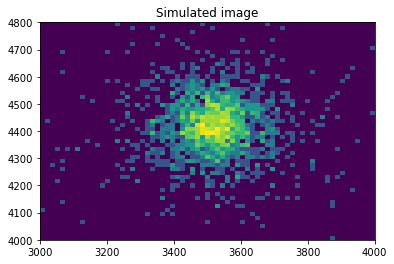

In [176]:
# Plot
plt.imshow(np.arcsinh(msim), origin='lower', cmap='viridis', 
           extent=(x0low, x0high, x1low, x1high), interpolation='nearest', aspect='auto')
plt.title('Simulated image')

In [177]:
# Rebin
msim_binned = rebin(msim,(16,13))

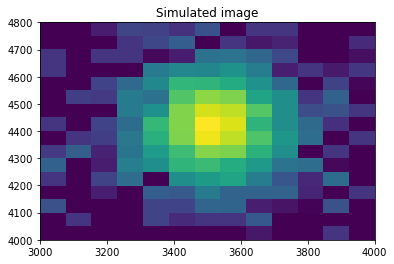

In [178]:
# Plot
plt.imshow(np.arcsinh(msim_binned), origin='lower', cmap='viridis', 
           extent=(x0low, x0high, x1low, x1high), interpolation='nearest', aspect='auto')
plt.title('Simulated image')
plt.savefig('fine_grid_img.png',dpi=300,bbox_inches='tight')